# Visualizations

In this notebook we create some visualizations of the trayectories of a typical directional exchange, and we explore some of the features of the interactions both in the synchronous case and in the time average. 

In [1]:
import sys
import os
sys.path.insert(0, './magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import jsonpickle
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloid as mgc
import matplotlib as mpl
import string as st

from tqdm import tqdm_notebook

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Load a trayectory file

In [2]:
directory = "D:/MapFrequencies2/"
index = pd.read_csv(os.path.join(directory,"index.dat"), sep = " ", names = ["name","frequency","tilt"])

In [3]:
def load_trj(name,directory):
    
    lz_trj = mgc.trj_lazyread(os.path.join(directory,name),["x","y","z","mux","muy","muz","fx","fy"])
    trj = lz_trj[:]
        
    bounds = lz_trj.get_bounds()
        
    return trj, bounds

From Notebook 39 we saw that this is a nice example of a directional exchange case. 

In [4]:
f = index.frequency.unique()[17]
t = index.tilt.unique()[9]

name = index[(index.tilt == t) & (index.frequency==f)].index
index.loc[name]

,name,frequency,tilt
457,Tilt_5.625_deg_freq4.38_2019_03_02_21_53_46,4.382385,5.625


In [5]:
trj,bounds = load_trj(index.loc[name]["name"].values[0]+".lammpstrj",directory)

In [6]:
video_large = mgc.animate_trj(trj,
                              region = bounds.loc[0].values, radius = 1.4,
                              framerate = 75, start = 15, end = 16, step=1,speedup=0.1)
video_large = video_large.to_html5_video()
HTML(video_large)

### Zooming into a single dimer interaction

In [7]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_xlim([-7.5,2.5])
ax.set_ylim([-5,5])

ax.set_xlabel("$x [\mu{m}]$")
ax.set_ylabel("$y [\mu{m}]$")

video_small = mgc.animate_trj(trj, ax = ax,
                              region = bounds.loc[0].values, radius = 1.4,
                              framerate = 75, start = 15, end = 16, step=1,speedup=0.1,preserve_limits = True)
video_small = video_small.to_html5_video()
HTML(video_small)

Now let's find a way to visualize this along with the external field. The `trj` dataset has stored the values of the magnetic moment of each particle. But this is not exactly proportional to the external field because we are calculating induced dipole. However, we can use it to ensure that we have the correct phase. 

The expression we are using for the field is:

In [8]:
Bmag = 7.28*ureg.mT
theta = 27*ureg.deg
freq = index.loc[name].frequency.values*ureg.Hz
tilt = index.loc[name].tilt.values*ureg.degree

B = lambda t: Bmag*np.array([
    np.sin(freq*t*2*np.pi)*np.sin(theta)+np.sin(tilt),
    np.cos(freq*t*2*np.pi)*np.sin(theta),
    np.cos(theta)*np.cos(tilt)])

In [9]:
framerate = 75
start = 15
end = 16
step = 1
speedup=0.1
timestep = 100*ureg.us

frame_id_min=np.uint(start*framerate)
frame_id_max=np.uint(end*framerate)

frames = trj.index.get_level_values('frame').unique().values

time = (frames[frame_id_min:frame_id_max:step]*timestep).to(ureg.sec)

In [10]:
B(time[0])

<Quantity([[-0.72056198]
 [-2.97769063]
 [ 6.45529309]], 'millitesla')>

It turns out matplotlib has no 3D arrow implemented.

In [11]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import matplotlib.animation as anm

In [12]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

### The cell below creates an animation of the field.

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection="3d")
ax.view_init(20, 70)

Blim = np.array([-0.5,0.5])*Bmag.magnitude
ax.set_xlim(Blim)
ax.set_ylim(Blim)
ax.set_zlim([0,Bmag.magnitude])
ax._axis3don = False
ax.set_aspect("equal")

z = Arrow3D([0,0],[0,0],[0,Bmag.magnitude], mutation_scale=20, lw=1, arrowstyle="-", color="k")
y = Arrow3D([0,0],[0,Bmag.magnitude],[0,0], mutation_scale=20, lw=1, arrowstyle="-", color="k")
x = Arrow3D([0,Bmag.magnitude],[0,0],[0,0], mutation_scale=20, lw=1, arrowstyle="-", color="k")

a = Arrow3D([0,0],[0,0],[0,0], mutation_scale=20, lw=1, arrowstyle="-|>", color="b")

ax.add_artist(x);
ax.add_artist(y);
ax.add_artist(z);
ax.add_artist(a);

B_array = np.array([B(t).magnitude[:,0] for t in time])
ax.plot(B_array[:,0],B_array[:,1],B_array[:,2])

def init():
    a = Arrow3D([0,0],[0,0],[0,0], mutation_scale=20, lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(a);
    return a,

def animate(frame):
    a.remove()
    B_plot = B(time[frame]).magnitude
    a._verts3d = ([0,B_plot[0]],[0,B_plot[1]],[0,B_plot[2]])
    ax.add_artist(a);
    return a,
    
dt_video = 1000/framerate/speedup # video timestep in miliseconds
anim = anm.FuncAnimation(fig, animate, init_func=init,
                               frames=len(time), interval=dt_video, blit=True);
plt.close(anim._fig)
video_field = anim.to_html5_video()

In [14]:
HTML("""<div class="row">
  <div class="col-sm-4">%s</div>
  <div class="col-sm-4">%s</div></div>
  <div class="row">
  <div class="col-sm-4">particles</div>
  <div class="col-sm-4">field</div></div>"""%(video_small,video_field))

# Two particle collision

Let's find the two particles observed in the example above.

We'll constrain ourselves to the time period shown in the animation

In [15]:
framerate = 75
start = 15
end = 16
step = 1
speedup=0.1
timestep = 100*ureg.us

frame_id_min=np.uint(start*framerate)
frame_id_max=np.uint(end*framerate)

frames = trj.index.get_level_values('frame').unique().values
frames = frames[frame_id_min:frame_id_max:step]

And also to particles which are in the animation region.

In [16]:
trj_subset = trj.loc[idx[frames,:],:]
trj_subset = trj_subset[
    (trj_subset.x>-7.5) & 
    (trj_subset.x< 2.5) & 
    (trj_subset.y>-5.0) & 
    (trj_subset.y< 5.0)]

Most of the particles come and go. However, the two particles with the longest trayectory inside the observed region are the ones which collide in the middle

In [17]:
indices = trj_subset.index.get_level_values("id").unique()[trj_subset.groupby("id").count().x>50]
trj_pair = trj_subset.loc[idx[:,indices],:]

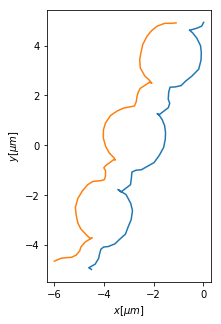

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
#ax.set_xlim([-7.5,2.5])
#ax.set_ylim([-5,5])

ax.set_aspect("equal")

ax.set_xlabel("$x [\mu{m}]$")
ax.set_ylabel("$y [\mu{m}]$")

for i, trj_single in trj_pair.loc[idx[frames,:],:].groupby("id"):
    plt.plot(trj_single.x,trj_single.y)

We now have our two particles. We'll make a dataset of each. 

In [19]:
trj_low = trj_pair.loc[idx[:,indices[0]],:].copy(deep=True)
trj_high = trj_pair.loc[idx[:,indices[1]],:].copy(deep=True)

trj_low.index = trj_low.index.get_level_values("frame")
trj_high.index = trj_high.index.get_level_values("frame")

trj_low["t"] = trj_low.index.values*timestep.to(ureg.sec)
trj_high["t"] = trj_high.index.values*timestep.to(ureg.sec)

trj_low = trj_low.set_index(["t"])
trj_high = trj_high.set_index(["t"])

In [20]:
trj_low = trj_low+trj_high-trj_high
trj_high = trj_low+trj_high-trj_low

Then we calculate the vector that separates both particles.

In [21]:
separation = trj_low-trj_high
separation = separation.filter(["x","y","z"])
separation["magnitude"] = np.sqrt((separation**2).sum(axis=1))

time = separation.index.values

We use the expression above to calculate the value of the field

In [22]:
Bmag = 7.28*ureg.mT
theta = 27*ureg.deg
freq = index.loc[name].frequency.values*ureg.Hz
tilt = index.loc[name].tilt.values*ureg.degree

B = lambda t: Bmag*np.array([
    np.sin(freq*t*2*np.pi)*np.sin(theta)+np.sin(tilt),
    np.cos(freq*t*2*np.pi)*np.sin(theta),
    np.cos(theta)*np.cos(tilt)])

In [23]:
field = np.array([B(t*ureg.s).magnitude[:,0] for t in (separation.index.values)])
field = pd.DataFrame(data=field, columns = ["x","y","z"], index = separation.index)
field["magnitude"] = np.sqrt((field**2).sum(axis=1))

The relative angle $\phi$ between the field vector $\vec{B}$ and the separation vector $\vec{r}_{ij}$ is given by:
$$\cos(\phi) = \frac{\vec{B}\cdot\vec{r}_{ij}}{\left|\vec{B}\right|\left|\vec{r}_{ij}\right|}$$

In [24]:
separation["rel_angle"] = np.arccos(
    (field*separation)[["x","y","z"]].sum(axis=1) / \
    (np.sqrt((field[["x","y","z"]]**2).sum(axis=1))*np.sqrt((separation[["x","y","z"]]**2).sum(axis=1))))

separation["rel_angle_inplane"] = np.arccos(
    (field*separation)[["x","y"]].sum(axis=1) / \
    (np.sqrt((field[["x","y"]]**2).sum(axis=1))*np.sqrt((separation[["x","y"]]**2).sum(axis=1))))

In [25]:
separation.head()

,x,y,z,magnitude,rel_angle,rel_angle_inplane
t,,,,,,
14.9625,NaN,NaN,NaN,0.0,NaN,NaN
14.9758,NaN,NaN,NaN,0.0,NaN,NaN
14.9891,NaN,NaN,NaN,0.0,NaN,NaN
15.0024,NaN,NaN,NaN,0.0,NaN,NaN
15.0157,NaN,NaN,NaN,0.0,NaN,NaN


In [26]:
def dipole_dipole(r,m1,m2, scaling = None):
    
    m1units = m1.units
    m2units = m2.units
    
    r = r.to(ureg.um).magnitude
    m1 = m1.magnitude
    m2 = m2.magnitude
        
    rmag = np.linalg.norm(r)
    
    if scaling is None:
        u0 = 4e-7*np.pi*ureg.N/ureg.A**2
        scaling = 3/4/np.pi*u0

    first_term = (np.cross(np.cross(r,m1),m2) + np.cross(np.cross(r,m2),m1))/rmag**5
    second_term = -(2*np.dot(m1,m2)*r)/rmag**5
    third_term = 5*np.dot(np.cross(r,m1),np.cross(r,m2))*r/rmag**7
    
    force = scaling * (first_term+second_term+third_term) * (m1units*m2units) / ureg.um**4
    
    return force.to(ureg.pN).magnitude

In [27]:
u0 = 4e-7*np.pi*ureg.N/ureg.A**2
r = 1.4*ureg.um
Volume = 4/3*np.pi*r**3
susceptibility = 0.4
VolSus = susceptibility*Volume/u0

In [28]:
interactions = pd.DataFrame(index=separation.index)

interactions = pd.DataFrame([dipole_dipole(r.values*ureg.um,
                                           field.loc[t,["x","y","z"]].values*ureg.mT*VolSus,
                                           field.loc[t,["x","y","z"]].values*ureg.mT*VolSus)
                             for t,r in separation.filter(["x","y","z"]).iterrows()],
                            index=separation.index,columns = ["x","y","z"])

interactions["magnitude"] = [np.linalg.norm(F) for t,F in interactions.iterrows()]
interactions["normal_force"] = [np.dot(F[["x","y","z"]],separation.loc[t,["x","y","z"]]) 
                                for t,F in interactions.iterrows()]

In [29]:
dimer_region = separation.magnitude[((separation.magnitude<2.81) & (separation.magnitude>0))].index[[0,-1]]
region = ((dimer_region[0],-20),np.diff(dimer_region)[0],30)

In [ ]:
ax.set_xlabel("$x [\mu{m}]$")
ax.set_ylabel("$y [\mu{m}]$")

for i, trj_single indd trj_pair.loc[idx[frames,:],:].groupby("id"):
    plt.plot(trj_single.x,trj_single.y)

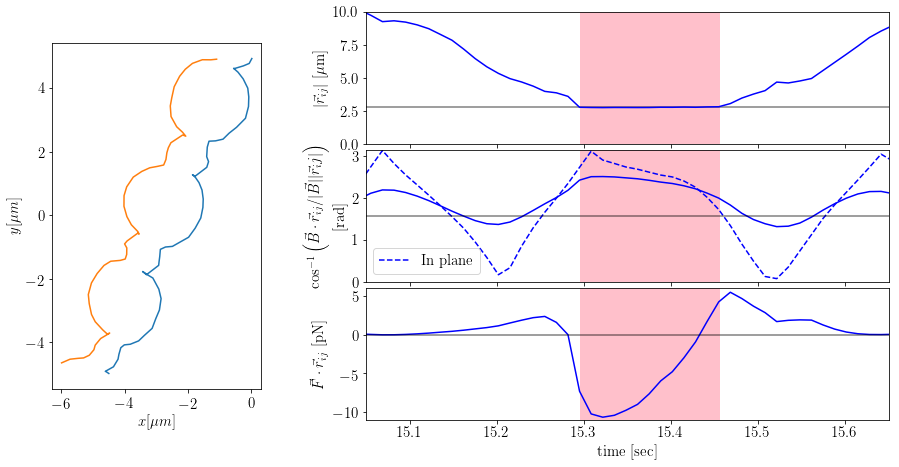

In [88]:
fig = plt.figure(figsize=(15,7.5))
gs = mpl.gridspec.GridSpec(3, 3, figure=fig, hspace=.05, wspace=0.5)

ax0 = fig.add_subplot(gs[:, 0])
ax3 = fig.add_subplot(gs[2,1:])
ax1 = fig.add_subplot(gs[0,1:],sharex=ax3)
ax2 = fig.add_subplot(gs[1,1:],sharex=ax3)

ax0.set_xlabel("$x [\mu{m}]$")
ax0.set_ylabel("$y [\mu{m}]$")

for i, trj_single in trj_pair.loc[idx[frames,:],:].groupby("id"):
    ax0.plot(trj_single.x,trj_single.y)
ax0.set_aspect("equal")
    
ax1.add_patch(mpl.patches.Rectangle(*region,color="pink"))

ax1.plot(separation.index,separation.index*0+2.8,color='k',alpha= 0.5)
ax1.plot(separation.magnitude, color="blue")
ax1.set_ylim([0,10])
ax1.set_ylabel(r"$\left|\vec{r}_{ij}\right|$ [$\mu{}$m]")
#plt.setp(ax1.get_xticklabels(), visible=False)

ax2.plot(separation.rel_angle, color="blue", label = "_nolegend_")
ax2.plot(separation.rel_angle_inplane,'--',color="blue", label = "In plane")
ax2.plot(separation.index,separation.index*0+np.pi/2,color='k',alpha = 0.5,label = "_nolegend_")
ax2.legend()
ax2.add_patch(mpl.patches.Rectangle(*region,color="pink"))
plt.setp(ax2.get_xticklabels(), visible=False)

ax2.set_ylim([0,np.pi])
ax2.set_ylabel(r"$\cos^{-1}\left(\vec{B}\cdot\vec{r}_{ij}/|\vec{B}||\vec{r}_ij|\right)$"+"\n [rad]")

ax3.plot(interactions.normal_force, color="blue")
ax3.plot(separation.index,separation.index*0,color='k',alpha = 0.5)
ax3.set_ylabel(r"$\vec{F}\cdot\vec{r}_{ij}$ [pN]")

xlim = [15.05,15.65]
ax3.set_xlim(xlim)

ax3.add_patch(mpl.patches.Rectangle(*region,color="pink"))
ax3.set_ylim([-11,6])
ax3.set_xlabel(r"time [sec]");

fig.savefig('dimer_formation_exchange.pdf',pad_inches=0.1,bbox_inches='tight')

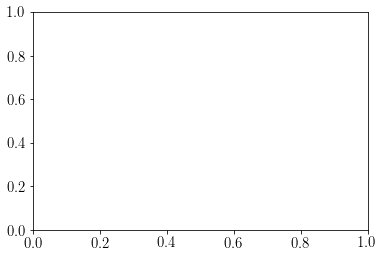

In [92]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
plt.xlim([-7.5,2.5])
plt.ylim([-5,5])
ax.set_aspect("equal")

a = plt.arrow(0,0,0,0, width = 0.1)
b = plt.arrow(0,0,0,0, width = 0.1, edgecolor=None, facecolor = "red")
c = plt.arrow(0,0,0,0, width = 0.1, edgecolor=None, facecolor = "red") 

def init():
    
    ax.add_artist(a);
    ax.add_artist(b);
    ax.add_artist(c);  
    return a, b, c

def animate(frame):
    
    t = time[frame]
    
    r0 = np.array([trj_low.loc[t].x,trj_low.loc[t].y])
    dr = np.array([trj_high.loc[t].x,trj_high.loc[t].y])-r0

    B_vec = B(t*ureg.sec).magnitude[0:2,0]
    B_vec = B_vec/np.linalg.norm(B_vec)

    a1 = plt.arrow(*r0,*dr, width = 0.1)
    a.set_xy(a1.get_xy())
    b1 = plt.arrow(*(r0-B_vec/2),*B_vec, width = 0.1, edgecolor=None, facecolor = "red")
    b.set_xy(b1.get_xy())
    c1 = plt.arrow(*(r0+dr-B_vec/2),*B_vec, width = 0.1, edgecolor=None, facecolor = "red")
    c.set_xy(c1.get_xy())
    
    #ax.add_artist(a);
    #ax.add_artist(b);
    #ax.add_artist(c);
    
    return a, b, c
    
dt_video = 1000/framerate/speedup # video timestep in miliseconds

anim = anm.FuncAnimation(fig, animate, init_func=init,
                               frames=len(time), interval=dt_video, blit=True);
plt.close(fig)

video_field = anim.to_html5_video()
plt.close(fig)

In [95]:
HTML(video_field)

# Interactions